# 分位点回帰

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp

import statsmodels.api as sm

import japanize_matplotlib

# 色テーマ指定
plt.style.use("ggplot")

線形計画法による分位点回帰モデルの推定

In [2]:
def qr(y, X, tau, alpha=0.05):
    n, p = X.shape

    beta = cp.Variable(p)
    r_p = cp.Variable(n)
    r_n = cp.Variable(n)

    ones = np.ones(n)
    obj = cp.Minimize(tau * ones @ r_p + (1 - tau) * ones @ r_n)
    constraints = [y - X @ beta == r_p - r_n, r_p >= 0, r_n >= 0]
    prob = cp.Problem(obj, constraints=constraints)

    result = prob.solve(solver=cp.SCS)

    # confidence interval (加藤、国友、増田 2009)
    # optimum bandwidth
    ppf_norm = stats.norm.ppf(tau)
    z = stats.norm.ppf(1 - alpha / 2)
    logh = (
        -np.log(n) / 3
        + np.log(z) * 2 / 3
        + (
            np.log(1.5)
            + 2 * np.log(stats.norm.pdf(ppf_norm))
            - np.log(2 * ppf_norm**2 + 1)
        )
        / 3
    )
    h = np.exp(logh)

    # sparsity function
    resid = r_p.value - r_n.value
    eps = 1e-5
    low, high = max(eps, tau - h), min(tau + h, 1 - eps)
    s = (np.quantile(resid, high) - np.quantile(resid, low)) / (high - low)

    # covariance estimator
    C = X.T @ X / n
    cov = tau * (1 - tau) * s**2 * np.linalg.inv(C) / n

    return beta.value, cov

非ガウスデータに対する頑健な推定例

$$
y_i = 1 + 2 x_i + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{t}(1)
$$

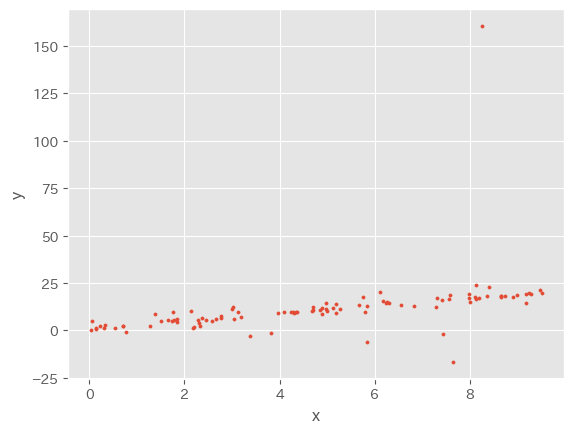

In [3]:
N = 100
rng = np.random.default_rng(123)

x = rng.uniform(0, 10, size=N)
eps = rng.standard_t(df=1, size=N)
y = 1 + 2 * x + eps

df = pd.DataFrame.from_dict({"y": y, "x": x})

plt.scatter(x, y, s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

tau=0.025 	 sample ratio under the estimated line: 0.02
tau=0.25 	 sample ratio under the estimated line: 0.25
tau=0.5 	 sample ratio under the estimated line: 0.49
tau=0.75 	 sample ratio under the estimated line: 0.75
tau=0.975 	 sample ratio under the estimated line: 0.96


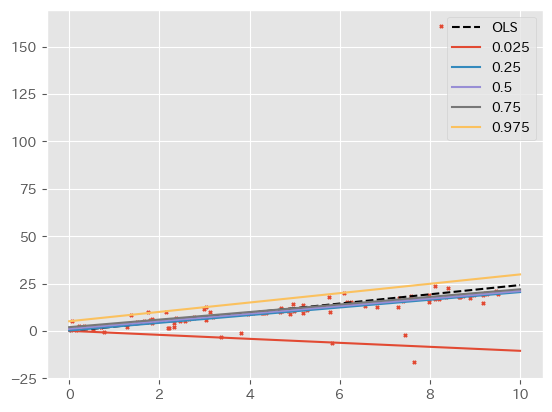

In [4]:
y = df["y"].values
X = sm.add_constant(df["x"]).values

x_lin = np.linspace(0, 10)
plt.scatter(X[:, 1], y, s=5, marker="x")

ols = sm.OLS(y, X).fit()
plt.plot(
    x_lin, ols.predict(sm.add_constant(x_lin[:, None])), c="k", ls="--", label="OLS"
)

for tau in [0.025, 0.25, 0.5, 0.75, 0.975]:
    beta, _ = qr(y, X, tau=tau)
    plt.plot(x_lin, beta[0] + beta[1] * x_lin, label=tau)

    print(
        f"{tau=} \t sample ratio under the estimated line: {np.count_nonzero(X @ beta > y) / len(y)}"
    )
plt.legend()
plt.show()

tau=0.025 	 sample ratio under the estimated line: 0.02
tau=0.25 	 sample ratio under the estimated line: 0.25
tau=0.5 	 sample ratio under the estimated line: 0.49
tau=0.75 	 sample ratio under the estimated line: 0.75
tau=0.975 	 sample ratio under the estimated line: 0.96


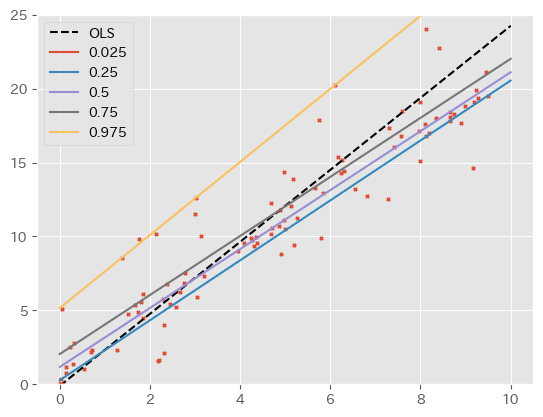

In [5]:
# 上の図だとよく分からないので、yの範囲を区切って拡大する
# 切片だけ違う平行な直線がたくさんできる


y = df["y"].values
X = sm.add_constant(df["x"]).values

x_lin = np.linspace(0, 10)
plt.scatter(X[:, 1], y, s=5, marker="x")

ols = sm.OLS(y, X).fit()
plt.plot(
    x_lin, ols.predict(sm.add_constant(x_lin[:, None])), c="k", ls="--", label="OLS"
)

for tau in [0.025, 0.25, 0.5, 0.75, 0.975]:
    beta, _ = qr(y, X, tau=tau)
    plt.plot(x_lin, beta[0] + beta[1] * x_lin, label=tau)

    print(
        f"{tau=} \t sample ratio under the estimated line: {np.count_nonzero(X @ beta > y) / len(y)}"
    )
plt.legend()
plt.ylim(0, 25)
plt.show()

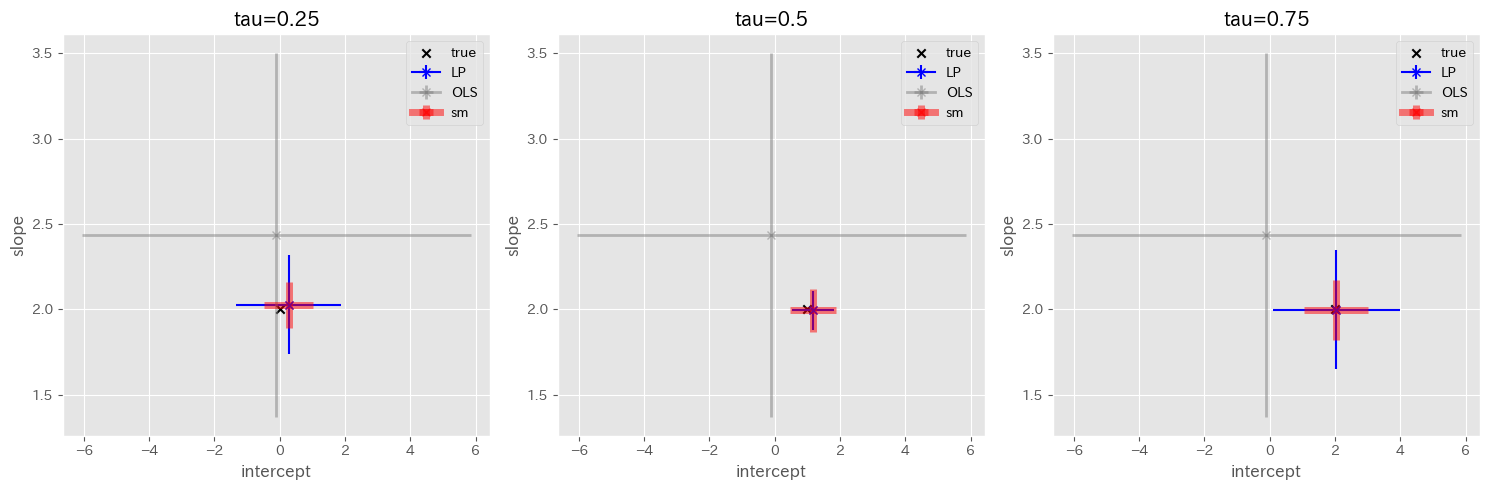

In [6]:
plt.figure(figsize=(15, 5))
for i, tau in enumerate([0.25, 0.5, 0.75]):
    beta, cov = qr(y, X, tau=tau)
    dev = 1.96 * np.sqrt(np.diag(cov))

    plt.subplot(1, 3, i + 1)
    plt.title(f"{tau=}")
    plt.scatter(
        1 + stats.t(df=1).ppf(tau),
        2,
        marker="x",
        c="black",
        label="true",
    )

    plt.errorbar(
        beta[0], beta[1], xerr=dev[0], yerr=dev[1], marker="x", c="b", label="LP"
    )

    conf_int = ols.conf_int(alpha=0.05)
    dev = [
        np.array(
            [ols.params[j] - conf_int[j][0], conf_int[j][1] - ols.params[j]]
        ).reshape(-1, 1)
        for j in [0, 1]
    ]
    plt.errorbar(
        ols.params[0],
        ols.params[1],
        xerr=dev[0],
        yerr=dev[1],
        marker="x",
        c="gray",
        label="OLS",
        alpha=0.5,
        lw=2,
    )

    sm_res = sm.QuantReg(y, X).fit(q=tau, vcov="iid", bandwidth="hsheather")
    conf_int = sm_res.conf_int(alpha=0.05)
    dev = [
        np.array(
            [sm_res.params[j] - conf_int[j][0], conf_int[j][1] - sm_res.params[j]]
        ).reshape(-1, 1)
        for j in [0, 1]
    ]
    plt.errorbar(
        sm_res.params[0],
        sm_res.params[1],
        xerr=dev[0],
        yerr=dev[1],
        marker="x",
        c="r",
        label="sm",
        alpha=0.5,
        lw=5,
    )

    plt.legend()
    plt.xlabel("intercept")
    plt.ylabel("slope")

plt.tight_layout()
plt.show()

# 信頼区間に違いがある
# OLSの場合、傾きが大きめに、切片が小さめに推定されている

傾きも分位点によって異なる例

$$
y_i = 1 + 2 x_i + (x_i + 1) \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, 1)
$$

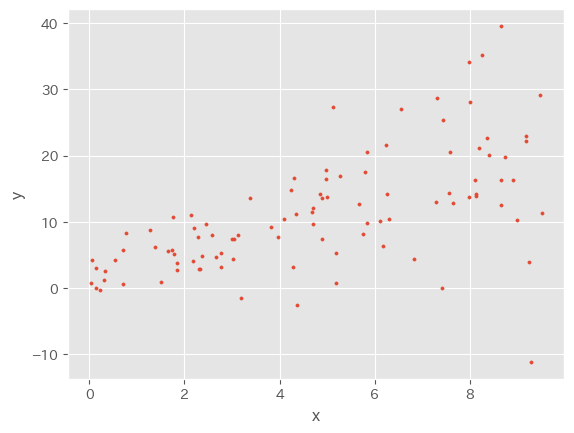

In [7]:
N = 100
rng = np.random.default_rng(123)

x = rng.uniform(0, 10, size=N)
eps = rng.normal(loc=0, scale=1, size=N)
y = 1 + 2 * x + (x + 2) * eps

df = pd.DataFrame.from_dict({"y": y, "x": x})

plt.scatter(x, y, s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

tau=0.025 	 sample ratio under the estimated line: 0.01
tau=0.25 	 sample ratio under the estimated line: 0.24
tau=0.5 	 sample ratio under the estimated line: 0.49
tau=0.75 	 sample ratio under the estimated line: 0.75
tau=0.975 	 sample ratio under the estimated line: 0.98


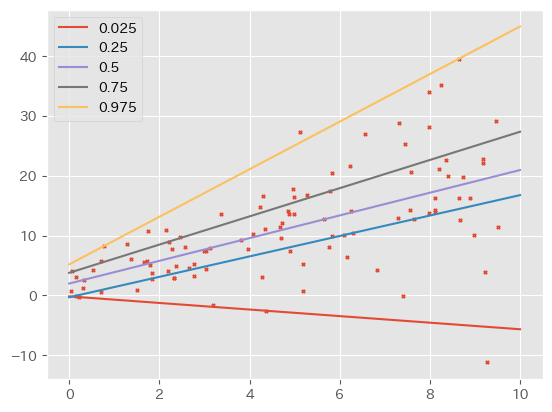

In [8]:
y = df["y"].values
X = sm.add_constant(df["x"]).values

x_lin = np.linspace(0, 10)
plt.scatter(X[:, 1], y, s=5, marker="x")
for tau in [0.025, 0.25, 0.5, 0.75, 0.975]:
    beta, _ = qr(y, X, tau=tau)
    plt.plot(x_lin, beta[0] + beta[1] * x_lin, label=tau)

    print(
        f"{tau=} \t sample ratio under the estimated line: {np.count_nonzero(X @ beta > y) / len(y)}"
    )
plt.legend()
plt.show()

係数と信頼区間をstatsmodelsと比較

/home/hayato/.pyenv/versions/miniconda3-latest/envs/main/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


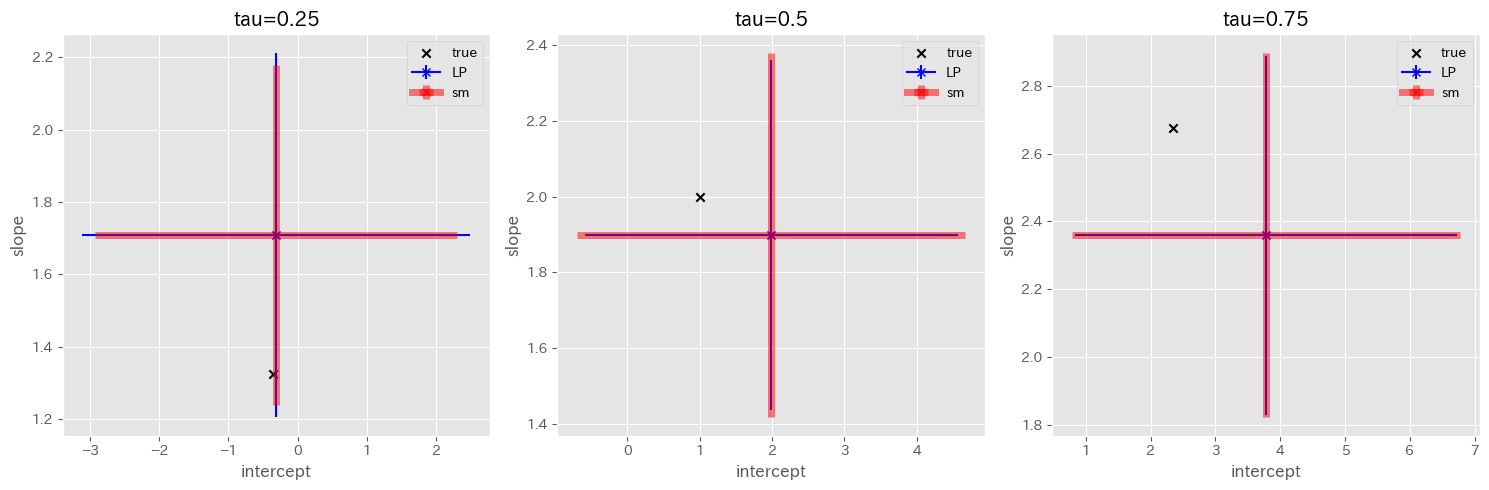

In [9]:
plt.figure(figsize=(15, 5))
for i, tau in enumerate([0.25, 0.5, 0.75]):
    beta, cov = qr(y, X, tau=tau)
    dev = 1.96 * np.sqrt(np.diag(cov))

    plt.subplot(1, 3, i + 1)
    plt.title(f"{tau=}")
    plt.scatter(
        1 + 2 * stats.norm().ppf(tau),
        2 + stats.norm().ppf(tau),
        marker="x",
        c="black",
        label="true",
    )

    plt.errorbar(
        beta[0], beta[1], xerr=dev[0], yerr=dev[1], marker="x", c="b", label="LP"
    )

    sm_res = sm.QuantReg(y, X).fit(q=tau, vcov="iid", bandwidth="hsheather")
    conf_int = sm_res.conf_int(alpha=0.05)
    dev = [
        np.array(
            [sm_res.params[j] - conf_int[j][0], conf_int[j][1] - sm_res.params[j]]
        ).reshape(-1, 1)
        for j in [0, 1]
    ]
    plt.errorbar(
        sm_res.params[0],
        sm_res.params[1],
        xerr=dev[0],
        yerr=dev[1],
        marker="x",
        c="r",
        label="sm",
        alpha=0.5,
        lw=5,
    )

    plt.legend()
    plt.xlabel("intercept")
    plt.ylabel("slope")

plt.tight_layout()
plt.show()

# 信頼区間に少し違いがある

実データへの応用例

元データ：改訂版 日本統計学会公式認定　統計検定2級対応　統計学基礎 配布データ http://tokyo-tosho.co.jp/download/


In [10]:
df = pd.read_csv("../data/room.csv", encoding="cp932")
df.head()

,近さ,家賃,間取り,大きさ,方角,築年数
0,B,68000,1K,19,西,12
1,B,68000,1K,19,南,12
2,B,69000,1K,19,北西,14
3,B,70000,1K,19,南,14
4,B,72000,1K,15,南,9


(0.0, 154100.0)

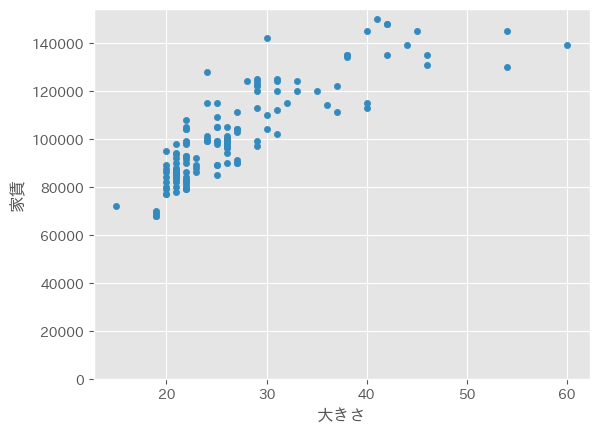

In [11]:
df.plot.scatter(x="大きさ", y="家賃")
plt.ylim(0, None)

tau=0.25 	 sample ratio under the estimated line: 0.25
tau=0.5 	 sample ratio under the estimated line: 0.5071428571428571
tau=0.75 	 sample ratio under the estimated line: 0.7571428571428571


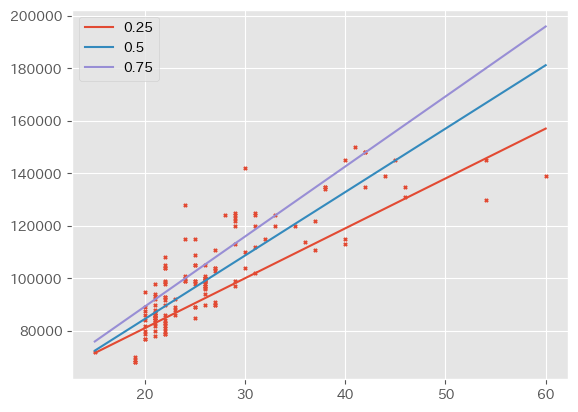

In [12]:
y = df["家賃"].values
X = sm.add_constant(df["大きさ"]).values

x_lin = np.linspace(15, 60)
plt.scatter(X[:, 1], y, s=5, marker="x")
for tau in [0.25, 0.5, 0.75]:
    beta, _ = qr(y, X, tau=tau)
    plt.plot(x_lin, beta[0] + beta[1] * x_lin, label=tau)

    print(
        f"{tau=} \t sample ratio under the estimated line: {np.count_nonzero(X @ beta > y) / len(y)}"
    )
plt.legend()
plt.show()